# CNN Cancer Detection Kaggle Mini-Project

In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.

In [16]:
# Libraries
import numpy as np
import pandas as pd
import os
from PIL import Image
import random
import io
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import torchvision.transforms as T
from torchvision.models import ResNet50_Weights

In [11]:
# Compression transform
class JPEGCompression:
    def __init__(self, quality_range=(80, 100)):
        self.quality_range = quality_range

    def __call__(self, img):
        quality = random.randint(self.quality_range[0], self.quality_range[1])
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG", quality=quality)
        buffer.seek(0)
        return Image.open(buffer).convert("RGB")

# Training transformations with augmentation
data_transforms_resnet = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2)], p=0.5),
    T.RandomAffine(degrees=15, scale=(0.9, 1.1)),
    T.RandomApply([JPEGCompression(quality_range=(80, 100))], p=0.5),
    T.RandomApply([T.ColorJitter(hue=0.1, saturation=0.1)], p=0.5),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test transformations (no augmentation)
data_transforms_test_resnet = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
class CancerDataset(Dataset):
    def __init__(self, datafolder, indices, transform=None, labels_dict=None, datatype='train'):
        self.datafolder = datafolder
        self.indices = indices
        self.transform = transform
        self.labels_dict = labels_dict
        self.datatype = datatype
        if self.datatype == 'train':
            self.image_files = labels.iloc[indices]['id'].values
        else:
            self.image_files = os.listdir(datafolder)

    def __len__(self):
        return len(self.indices) if self.datatype == 'train' else len(self.image_files)

    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_id = self.image_files[idx]
            img_name = f"{img_id}.tif"
            label = self.labels_dict.get(img_id, 0)
        else:
            img_name = self.image_files[idx]
            label = 0  # Placeholder label for test data

        img_path = os.path.join(self.datafolder, img_name)
        try:
            image = Image.open(img_path).convert('RGB')  # Load and ensure RGB format
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black PIL Image in case of error
            image = Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8))

        if self.transform:
            image = self.transform(image)

        return image, label

Mounted at /content/drive
Labels path exists: True
Train dir exists: True
Test dir exists: True
Contents of /content/drive/My Drive/CNN Kaggle Cancer Detection Project: ['histopathologic-cancer-detection.zip', 'train_labels.csv', 'test', 'sample_submission.csv', 'train']
Total training samples: 220025
220025 pictures in train.
57458 pictures in test.
Label distribution:
label
0    130908
1     89117
Name: count, dtype: int64
Training samples: 198022
Validation samples: 22003


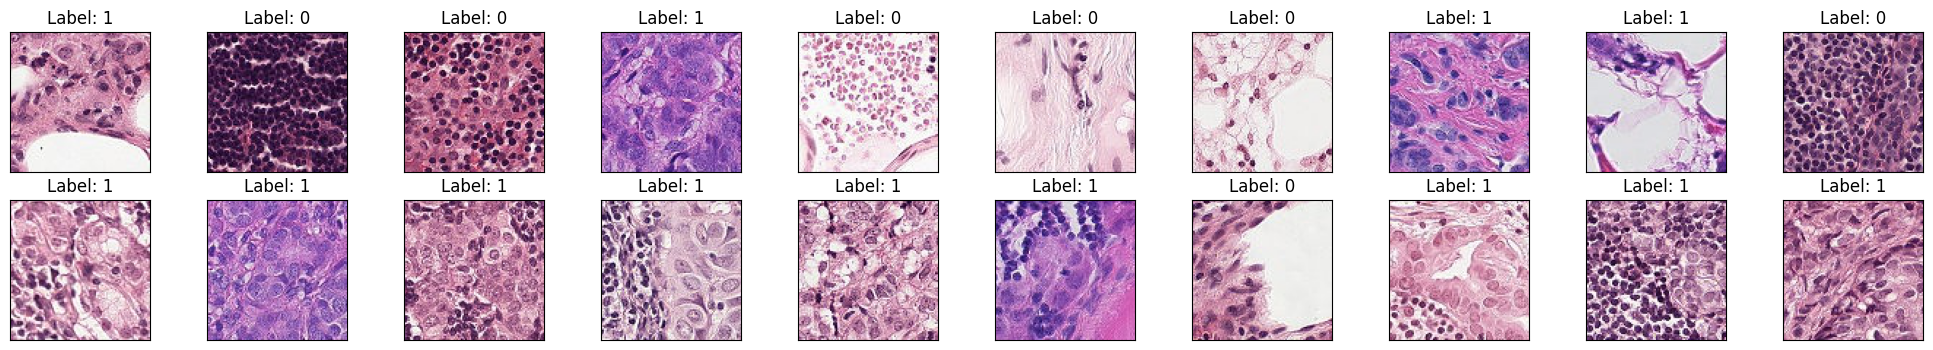

In [13]:
from google.colab import drive


# Mount Google Drive (force remount to ensure fresh connection)
drive.mount('/content/drive', force_remount=True)

# Define paths (updated to correct folder name)
folder_path = '/content/drive/My Drive/CNN Kaggle Cancer Detection Project'
labels_path = os.path.join(folder_path, 'train_labels.csv')
train_dir = os.path.join(folder_path, 'train')
test_dir = os.path.join(folder_path, 'test')

# Verify paths exist
print(f"Labels path exists: {os.path.exists(labels_path)}")
print(f"Train dir exists: {os.path.exists(train_dir)}")
print(f"Test dir exists: {os.path.exists(test_dir)}")
if os.path.exists(folder_path):
    print(f"Contents of {folder_path}: {os.listdir(folder_path)}")
else:
    raise FileNotFoundError(f"Folder {folder_path} not found. Please check the folder name.")

# Load train labels
if not os.path.exists(labels_path):
    raise FileNotFoundError(f"Could not find {labels_path}. Please upload train_labels.csv to {folder_path}.")
try:
    labels = pd.read_csv(labels_path)
    print(f'Total training samples: {len(labels)}')
except Exception as e:
    raise Exception(f"Error loading {labels_path}: {str(e)}")

# Verify image counts
if os.path.exists(train_dir):
    print(f'{len(os.listdir(train_dir))} pictures in train.')
else:
    print(f"Train directory {train_dir} not found.")
if os.path.exists(test_dir):
    print(f'{len(os.listdir(test_dir))} pictures in test.')
else:
    print(f"Test directory {test_dir} not found.")

# Visualize sample images
num_samples = 20
if os.path.exists(train_dir):
    try:
        sample_images = np.random.choice(os.listdir(train_dir), num_samples, replace=False)
        fig = plt.figure(figsize=(25, 4))
        for idx, img in enumerate(sample_images):
            ax = fig.add_subplot(2, num_samples // 2, idx + 1, xticks=[], yticks=[])
            img_path = os.path.join(train_dir, img)
            image = Image.open(img_path).convert('RGB')
            plt.imshow(image)
            img_id = img.split('.')[0]
            label = labels.loc[labels['id'] == img_id, 'label'].values[0]
            ax.set_title(f'Label: {label}')
        # plt.show()  # Commented out as in your latest submission
    except Exception as e:
        print(f"Error visualizing images: {str(e)}")
else:
    print("Skipping visualization: Train directory not found.")

# Check label distribution
print("Label distribution:")
print(labels['label'].value_counts())

# Split data into training and validation sets
test_size = 0.1
random_state = 42
try:
    train_indices, val_indices = train_test_split(
        labels.index,
        test_size=test_size,
        stratify=labels['label'],
        random_state=random_state
    )
    print(f"Training samples: {len(train_indices)}")
    print(f"Validation samples: {len(val_indices)}")
except Exception as e:
    raise Exception(f"Error splitting data: {str(e)}")

# Create a dictionary mapping image IDs to labels
img_class_dict = {row['id']: row['label'] for _, row in labels.iterrows()}

# Custom JPEG compression transform
class JPEGCompression:
    def __init__(self, quality_range=(80, 100)):
        self.quality_range = quality_range

    def __call__(self, img):
        quality = random.randint(self.quality_range[0], self.quality_range[1])
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG", quality=quality)
        buffer.seek(0)
        return Image.open(buffer).convert("RGB")

# Define transforms
data_transforms_resnet = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2)], p=0.5),
    T.RandomAffine(degrees=15, scale=(0.9, 1.1)),
    T.RandomApply([JPEGCompression(quality_range=(80, 100))], p=0.5),
    T.RandomApply([T.ColorJitter(hue=0.1, saturation=0.1)], p=0.5),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_transforms_test_resnet = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define CancerDataset class
class CancerDataset(Dataset):
    def __init__(self, datafolder, indices=None, transform=None, labels_dict=None, datatype='train'):
        self.datafolder = datafolder
        self.transform = transform
        self.labels_dict = labels_dict
        self.datatype = datatype
        self.image_files = [f for f in os.listdir(datafolder) if f.endswith('.tif')]  # Change to .jpg or .png if needed
        if indices is not None:
            self.image_files = [self.image_files[i] for i in indices]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, self.image_files[idx])
        try:
            image = Image.open(img_name).convert('RGB')
        except Exception as e:
            raise Exception(f"Error loading image {img_name}: {str(e)}")

        if self.datatype == 'train' and self.labels_dict is not None:
            img_id = self.image_files[idx].split('.')[0]
            label = self.labels_dict.get(img_id, 0)  # Default to 0 if not found
        else:
            label = 0  # Test mode: dummy label
            img_id = self.image_files[idx].split('.')[0]

        if self.transform:
            image = self.transform(image)

        return image, label, img_id  # Return img_id for test predictions

# Create datasets
try:
    train_dataset_resnet = CancerDataset(
        datafolder=train_dir,
        indices=train_indices,
        transform=data_transforms_resnet,
        labels_dict=img_class_dict,
        datatype='train'
    )

    val_dataset_resnet = CancerDataset(
        datafolder=train_dir,
        indices=val_indices,
        transform=data_transforms_test_resnet,
        labels_dict=img_class_dict,
        datatype='train'
    )

    test_dataset_resnet = CancerDataset(
        datafolder=test_dir,
        indices=None,
        transform=data_transforms_test_resnet,
        labels_dict=None,
        datatype='test'
    )
except Exception as e:
    raise Exception(f"Error creating datasets: {str(e)}")

# Define batch size and number of workers
batch_size_resnet = 32
num_workers = 4  # Reduce to 2 or 0 if memory issues occur

# Create DataLoaders
try:
    train_loader_resnet = DataLoader(
        train_dataset_resnet,
        batch_size=batch_size_resnet,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    valid_loader_resnet = DataLoader(
        val_dataset_resnet,
        batch_size=batch_size_resnet,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader_resnet = DataLoader(
        test_dataset_resnet,
        batch_size=batch_size_resnet,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
except Exception as e:
    raise Exception(f"Error creating DataLoaders: {str(e)}")

In [ ]:
# Define folder path (consistent with earlier code)
folder_path = '/content/drive/My Drive/CNN Kaggle Cancer Detection Project'

# Load the pretrained ResNet50 model
model_resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze all layers
for param in model_resnet.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 1)  # Binary classification

# Initialize the new layer's weights
nn.init.kaiming_normal_(model_resnet.fc.weight, mode='fan_out', nonlinearity='relu')
nn.init.zeros_(model_resnet.fc.bias)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

# Define loss, optimizer, and scheduler
criterion_resnet = nn.BCEWithLogitsLoss()
optimizer_resnet = optim.AdamW(model_resnet.fc.parameters(), lr=0.005, weight_decay=1e-4)
scheduler_resnet = CosineAnnealingLR(optimizer_resnet, T_max=10, eta_min=1e-6)
scaler = GradScaler()

# Training parameters
n_epochs_resnet = 3
valid_loss_min_resnet = np.inf
patience_resnet = 7
p_resnet = 0

# Training loop
for epoch in range(1, n_epochs_resnet + 1):
    start_time = time.time()
    print(f'\nEpoch {epoch}/{n_epochs_resnet}')
    print('-' * 30)

    # Training
    model_resnet.train()
    train_loss = 0.0
    n_batches = len(train_loader_resnet)
    preds_all = []
    targets_all = []

    for data, target, _ in train_loader_resnet:  # Adjusted to handle img_id from CancerDataset
        data, target = data.to(device, non_blocking=True), target.float().to(device, non_blocking=True).unsqueeze(1)
        optimizer_resnet.zero_grad(set_to_none=True)

        with autocast():
            output = model_resnet(data)
            loss = criterion_resnet(output, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer_resnet)
        scaler.update()

        train_loss += loss.item()
        preds_all.append(torch.sigmoid(output).detach())
        targets_all.append(target.detach())

    preds_all = torch.cat(preds_all).cpu().numpy()
    targets_all = torch.cat(targets_all).cpu().numpy()
    train_loss_avg = train_loss / n_batches
    train_auc_avg = roc_auc_score(targets_all, preds_all)

    # Validation
    model_resnet.eval()
    val_loss = 0.0
    n_batches = len(valid_loader_resnet)
    preds_all = []
    targets_all = []

    with torch.no_grad():
        for data, target, _ in valid_loader_resnet:  # Adjusted to handle img_id
            data, target = data.to(device, non_blocking=True), target.float().to(device, non_blocking=True).unsqueeze(1)
            with autocast():
                output = model_resnet(data)
                loss = criterion_resnet(output, target)
            val_loss += loss.item()
            preds_all.append(torch.sigmoid(output))
            targets_all.append(target)

    preds_all = torch.cat(preds_all).cpu().numpy()
    targets_all = torch.cat(targets_all).cpu().numpy()
    val_loss_avg = val_loss / n_batches
    val_auc_avg = roc_auc_score(targets_all, preds_all)

    # Print metrics
    print(f'Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f}')
    print(f'Train AUC: {train_auc_avg:.4f} | Val AUC: {val_auc_avg:.4f}')
    print(f"Epoch {epoch} completed in {(time.time() - start_time)/60:.2f} minutes")

    # Save model to Google Drive
    checkpoint_path = os.path.join(folder_path, 'model_resnet50.pt')
    if val_loss_avg < valid_loss_min_resnet:
        print(f'Validation loss decreased ({valid_loss_min_resnet:.6f} --> {val_loss_avg:.6f}). Saving model...')
        torch.save(model_resnet.state_dict(), checkpoint_path)
        valid_loss_min_resnet = val_loss_avg
        p_resnet = 0
    else:
        p_resnet += 1
        print(f'{p_resnet} epochs of no improvement.')
        if p_resnet > patience_resnet:
            print('Early stopping triggered.')
            break

    scheduler_resnet.step()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]



Epoch 1/3
------------------------------
Train Loss: 1.0224 | Val Loss: 0.5535
Train AUC: 0.8354 | Val AUC: 0.8858
Epoch 1 completed in 17.69 minutes
Validation loss decreased (inf --> 0.553496). Saving model...

Epoch 2/3
------------------------------
